In [1]:
%set_env CUDA_VISIBLE_DEVICES=1

from timeit import default_timer
from src.models.ResNet import *
from src.utils.trainer import *
from src.utils.tools import *
from src.utils.splitNN import SplitNN, SplitOptimizer
from src.utils.dataloader import cifar_10_dataloader
from torch.multiprocessing import set_start_method
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim import Adam, SGD
from torch import tensor
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import syft as sy

import torchvision
import shutil
import torch
import os
import gc

env: CUDA_VISIBLE_DEVICES=1


In [2]:
torch.manual_seed(0)

client_ids = list(range(10))
data_paths = {}
for c in client_ids:
    data_paths[c] = f'data/clients/client{c+1}/cifar10'

save_path = 'results/cifar10/non-iid'

# To get around the PyTorch issue described by me at:
# https://github.com/OpenMined/PySyft/issues/3848
# This, however, leads to inefficient use of GPU memory
# and problems related to multiprocessing

torch.set_default_tensor_type(torch.cuda.FloatTensor)
hook = sy.TorchHook(torch)

server_model = ResNetServer18(num_classes=10)
client_model = ResNetClient(num_channels=3)

criterion = nn.NLLLoss(reduction='mean')

# CIFAR-10 Optimal Hyperparameters are taken from:
# https://arxiv.org/abs/1708.04552v2

optim = SGD
optim_params = {
    'lr': 0.1, 
    'weight_decay': 5e-4,
    'momentum': 0.9
}

scheduler = MultiStepLR
scheduler_params = {
    'milestones': [60, 120, 160],
    'gamma': 0.2, 
}

dataloader_params = {
    #'shuffle' : True,
    'num_workers' : 8,
}

batch_size = 2048
batch_sizes = {}
for c in client_ids:
    batch_sizes[c] = int(batch_size * 0.1)

# PyTorch multiprocessing errors out with DataLoader tensors created on GPU 
# (as with torch.set_default_tensor_type(torch.cuda.FloatTensor)) and num_workers > 0.
# Therefore, we check if this is the case, and if so, change the spawn method. 
# More details at https://pytorch.org/docs/master/notes/multiprocessing.html
if torch.tensor([0]).is_cuda and dataloader_params['num_workers'] > 0:
    set_start_method('spawn', force=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Workers are automatically put on to the appropriate devices and clients
server = init_worker('server', server_model, hook, device, requires_grad=True) 
#                       finetune='./results/cifar100_baseline/alternating_training/batch_norm/split_learning/new_running_stats/epoch_20/server_trained_on_client_2.pth')

clients = {}
for c in client_ids:
    clients[c] = init_worker('client_'+str(c), client_model, hook, device, requires_grad=True)

splitNN = SplitNN(clients, server)
criterion = criterion.to(device)

# Optimizers
server_optim = optim(splitNN.server.parameters(), **optim_params)
client_optims = {}
for c, client in splitNN.clients.items():
    client_optims[c] = optim(client.parameters(), **optim_params)

split_optim = SplitOptimizer(client_optims, server_optim)

# Schedulers
server_scheduler = scheduler(split_optim.server, **scheduler_params)
client_schedulers = {}
for c, client_optim in split_optim.clients.items():
    client_schedulers[c] = scheduler(client_optim, **scheduler_params)

split_scheduler = SplitScheduler(client_schedulers, server_scheduler)
    
# Get the data
dataloaders = {}
for c in client_ids: 
    dataloaders[c] = {}
    dataloaders[c]['train'] = cifar_10_dataloader(data_paths[c], train=True, batch_size=batch_sizes[c], **dataloader_params)
    dataloaders[c]['val'] = cifar_10_dataloader(data_paths[c], train=False, batch_size=batch_sizes[c], **dataloader_params)

trainer = SplitTrainer(client_ids=client_ids, splitNN=splitNN, split_optim=split_optim,
                       split_scheduler=split_scheduler, dataloaders=dataloaders, criterion=criterion, 
                       num_epochs=200, save_path=save_path, verbose=2, device=device)
# trainer.cum_epochs = 20
# trainer.stats = torch.load(
#     './results/cifar100_baseline/alternating_training/batch_norm/split_learning/new_running_stats/client_trained_on_client_0.pth'
#     )['stats']

In [4]:
stats = trainer.train_alternate(train_clts=client_ids, val_clts=client_ids)

Training epoch 1. Learning rate: 0.1 --------------------------------------------------
Client 0. Loss: 0.554, accuracy: 0.00%
Client 1. Loss: 0.495, accuracy: 0.00%
Client 2. Loss: 0.671, accuracy: 0.00%
Client 3. Loss: 0.172, accuracy: 0.00%
Client 4. Loss: 0.094, accuracy: 100.00%
Client 5. Loss: 0.288, accuracy: 0.00%
Client 6. Loss: 1.577, accuracy: 0.00%
Client 7. Loss: 0.306, accuracy: 0.00%
Client 8. Loss: 0.224, accuracy: 0.00%
Client 9. Loss: 0.397, accuracy: 0.00%


Client 0. Loss: 0.315, accuracy: 0.00%
Client 1. Loss: 0.228, accuracy: 0.00%
Client 2. Loss: 0.233, accuracy: 0.00%
Client 3. Loss: 0.216, accuracy: 0.00%
Client 4. Loss: 0.207, accuracy: 0.00%
Client 5. Loss: 0.247, accuracy: 0.00%
Client 6. Loss: 0.620, accuracy: 0.00%
Client 7. Loss: 0.282, accuracy: 0.00%
Client 8. Loss: 0.217, accuracy: 1.96%
Client 9. Loss: 0.178, accuracy: 96.57%


Client 0. Loss: 0.242, accuracy: 0.00%
Client 1. Loss: 0.261, accuracy: 0.00%
Client 2. Loss: 0.253, accuracy: 0.00%
Client 3

Client 6. Loss: 0.151, accuracy: 72.06%
Client 7. Loss: 0.177, accuracy: 0.49%
Client 8. Loss: 0.165, accuracy: 0.00%
Client 9. Loss: 0.168, accuracy: 82.35%


Client 0. Loss: 0.166, accuracy: 7.84%
Client 1. Loss: 0.131, accuracy: 95.59%
Client 2. Loss: 0.077, accuracy: 100.00%
Client 3. Loss: 0.163, accuracy: 9.80%
Client 4. Loss: 0.129, accuracy: 75.49%
Client 5. Loss: 0.182, accuracy: 0.00%
Client 6. Loss: 0.147, accuracy: 89.22%
Client 7. Loss: 0.161, accuracy: 14.22%
Client 8. Loss: 0.150, accuracy: 88.73%
Client 9. Loss: 0.126, accuracy: 96.57%


Sample 0 out of 8. Loss: 1.255, accuracy: 84.80%
Val results for client 0, epoch 4: loss=1.25801, accuracy=81.65850

Sample 0 out of 8. Loss: 1.432, accuracy: 90.20%
Val results for client 1, epoch 4: loss=1.44128, accuracy=88.61316

Sample 0 out of 8. Loss: 1.118, accuracy: 96.08%
Val results for client 2, epoch 4: loss=1.11451, accuracy=95.99674

Sample 0 out of 8. Loss: 1.341, accuracy: 30.39%
Val results for client 3, epoch 4: loss=

Sample 0 out of 8. Loss: 0.342, accuracy: 100.00%
Val results for client 1, epoch 7: loss=0.34599, accuracy=100.00000

Sample 0 out of 8. Loss: 0.472, accuracy: 84.80%
Val results for client 2, epoch 7: loss=0.42772, accuracy=87.73489

Sample 0 out of 8. Loss: 0.390, accuracy: 98.04%
Val results for client 3, epoch 7: loss=0.37406, accuracy=98.78473

Sample 0 out of 8. Loss: 0.108, accuracy: 99.51%
Val results for client 4, epoch 7: loss=0.11093, accuracy=99.63235

Sample 0 out of 8. Loss: 1.295, accuracy: 0.00%
Val results for client 5, epoch 7: loss=1.28786, accuracy=0.00000

Sample 0 out of 8. Loss: 0.320, accuracy: 100.00%
Val results for client 6, epoch 7: loss=0.32159, accuracy=100.00000

Sample 0 out of 8. Loss: 0.743, accuracy: 96.57%
Val results for client 7, epoch 7: loss=0.73095, accuracy=96.47672

Sample 0 out of 8. Loss: 1.098, accuracy: 36.76%
Val results for client 8, epoch 7: loss=1.10853, accuracy=35.70262

Sample 0 out of 8. Loss: 0.104, accuracy: 100.00%
Val results 

Sample 0 out of 8. Loss: 0.895, accuracy: 16.18%
Val results for client 6, epoch 10: loss=0.87776, accuracy=21.12949

Sample 0 out of 8. Loss: 0.090, accuracy: 100.00%
Val results for client 7, epoch 10: loss=0.08776, accuracy=100.00000

Sample 0 out of 8. Loss: 0.083, accuracy: 100.00%
Val results for client 8, epoch 10: loss=0.08585, accuracy=100.00000

Sample 0 out of 8. Loss: 0.021, accuracy: 100.00%
Val results for client 9, epoch 10: loss=0.02141, accuracy=100.00000

Val results global, epoch 10: loss=0.18147, accuracy=92.09457

Training epoch 11. Learning rate: 0.1 --------------------------------------------------
Client 0. Loss: 0.021, accuracy: 100.00%
Client 1. Loss: 0.009, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%
Client 3. Loss: 0.010, accuracy: 100.00%
Client 4. Loss: 0.028, accuracy: 93.63%
Client 5. Loss: 0.096, accuracy: 2.45%
Client 6. Loss: 0.030, accuracy: 96.08%
Client 7. Loss: 0.006, accuracy: 100.00%
Client 8. Loss: 0.024, accuracy: 99.02%
Client

Training epoch 14. Learning rate: 0.1 --------------------------------------------------
Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%
Client 3. Loss: 0.003, accuracy: 100.00%
Client 4. Loss: 0.033, accuracy: 99.51%
Client 5. Loss: 0.028, accuracy: 100.00%
Client 6. Loss: 0.096, accuracy: 0.98%
Client 7. Loss: 0.016, accuracy: 100.00%
Client 8. Loss: 0.002, accuracy: 100.00%
Client 9. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.029, accuracy: 98.04%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%
Client 3. Loss: 0.002, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%
Client 5. Loss: 0.167, accuracy: 0.00%
Client 6. Loss: 0.028, accuracy: 100.00%
Client 7. Loss: 0.002, accuracy: 100.00%
Client 8. Loss: 0.002, accuracy: 100.00%
Client 9. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.006, accuracy: 100.00%
Client 2. L

KeyboardInterrupt: 

In [ ]:
def plot_val_loss(stats, save_path):
    val = stats['val']
    val_acc = pd.DataFrame(val['accuracy'])
    val_acc['Epoch'] = val_acc.index.values
    ax = val_acc.plot(x='Epoch', y=client_ids+['global'], kind='line')
    ax.set_ylabel("Accuracy")
    ax.legend(["Client 0", "Client 1", 'Client 2'])
    ax.figure.savefig(os.path.join(save_path, 'val_acc.png'))
    
    val_acc = pd.DataFrame(val['loss'])
    val_acc['Epoch'] = val_acc.index.values
    ax = val_acc.plot(x='Epoch', y=[0, 1, 2], kind='line')
    ax.set_ylabel("Loss")
    ax.legend(["Client 0", "Client 1", 'Client 2'])
    ax.figure.savefig(os.path.join(save_path, 'val_loss.png'))

In [11]:
# for mode in ['train', 'test']:
#     src_root = f'data/cifar10/{mode}'
#     for i, label in enumerate(os.listdir(src_root)):
#         src = os.path.join(src_root, label)
#         dest = f'data/clients/client{i+1}/cifar10/{mode}'
        
#         for f in os.listdir(dest):
#             if f == label:
#                 continue
#             shutil.move(os.path.join(dest, f), os.path.join(dest, label, f))

5000


             0          1          2   3     global
1    13.730072  26.133438   7.369074 NaN  14.726490
2    19.199275  40.798517  24.089104 NaN  25.881041
3    25.739129  43.721133  34.040085 NaN  32.612375
4    33.534419  55.546445  41.077192 NaN  41.136821
5    40.155796  57.043889  45.583893 NaN  45.877338
..         ...        ...        ...  ..        ...
146  71.655795  81.379336  76.726237 NaN  75.552661
147  72.842388  80.393085  76.854680 NaN  75.891657
148  72.621374  81.048823  76.507201 NaN  75.841196
149  71.137678  80.200067  76.873296 NaN  75.082460
150  72.949272  80.772954  76.128074 NaN  75.805625

[149 rows x 5 columns]
            0         1         2   3    global
1    3.544752  3.022858  4.214967 NaN  3.627542
2    3.350454  2.133594  2.981962 NaN  2.945202
3    3.010677  2.067880  2.635214 NaN  2.668825
4    2.599627  1.467057  2.210268 NaN  2.208073
5    2.264927  1.509193  2.071463 NaN  2.024208
..        ...       ...       ...  ..       ...
146  1.183214  0

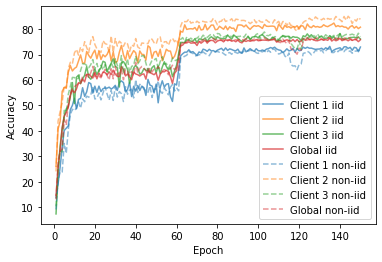

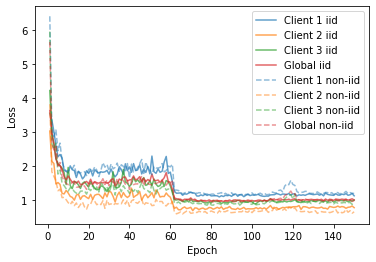

In [37]:
iid = torch.load('results/cifar10/iid/epoch_150/server_trained_on_client_3.pth')['stats']
non_iid = torch.load('results/cifar10/non-iid/epoch_150/server_trained_on_client_2.pth')['stats']

# Plot iid
val = iid['val']
val_acc = pd.DataFrame(val['accuracy'])
val_acc['Epoch'] = val_acc.index.values
ax = val_acc.plot(x='Epoch', y=[0, 1, 2]+['global'], kind='line', alpha=0.7)

# Plot iid
val = non_iid['val']
val_acc = pd.DataFrame(val['accuracy'])
val_acc['Epoch'] = val_acc.index.values
val_acc.plot(x='Epoch', y=[0, 1, 2]+['global'], kind='line', linestyle='--', 
             color=['C0', 'C1', 'C2', 'C3'], ax=ax, alpha=0.5)
ax.set_ylabel("Accuracy")
ax.legend(['Client 1 iid', 'Client 2 iid', 'Client 3 iid', 'Global iid', 
          'Client 1 non-iid', 'Client 2 non-iid', 'Client 3 non-iid', 'Global non-iid'])
ax.figure.savefig(os.path.join(save_path, 'val_acc.png'))

# Plot iid
val = iid['val']
val_acc = pd.DataFrame(val['loss'])
print(val_acc)
val_acc['Epoch'] = val_acc.index.values
ax = val_acc.plot(x='Epoch', y=[0, 1, 2]+['global'], kind='line', alpha=0.7)

# Plot iid
val = non_iid['val']
val_acc = pd.DataFrame(val['loss'])
val_acc['Epoch'] = val_acc.index.values
val_acc.plot(x='Epoch', y=[0, 1, 2]+['global'], kind='line', linestyle='--', 
             color=['C0', 'C1', 'C2', 'C3'], ax=ax, alpha=0.5)
ax.set_ylabel("Loss")
ax.legend(['Client 1 iid', 'Client 2 iid', 'Client 3 iid', 'Global iid', 
          'Client 1 non-iid', 'Client 2 non-iid', 'Client 3 non-iid', 'Global non-iid'])
ax.figure.savefig(os.path.join(save_path, 'val_loss.png'))